<a href="https://colab.research.google.com/github/abulhasanat/MachineLearning/blob/master/sentiment_analysis_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 665kB 3.4MB/s 
     |████████████████████████████████| 1.1MB 20.8MB/s 
     |████████████████████████████████| 890kB 29.5MB/s 
     |████████████████████████████████| 3.8MB 29.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=0440e2585a157bedff2822fbab79f9b564d6b859c3229cf5949dbeb11b6c27de
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cpu')

In [3]:
df = pd.read_csv("/content/drive/My Drive/Data/Google Play Review/reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOGt2KEhc-yNMmOBsXqfHKLGJ-vDENQPVPlGZIM...,Earl Clark,https://lh3.googleusercontent.com/a-/AOh14Gj_X...,"This is an expensive app. That being said, it'...",1,120,5.0.0.11,2020-05-16 15:23:38,We are not aware of any issues with editing ta...,2020-05-17 10:06:29,most_relevant,com.anydo
1,gp:AOqpTOFnIu5LAl0bREEIRnyqUs95zFeDP4kQ-eY638E...,Elad Posner,https://lh3.googleusercontent.com/a-/AOh14Ghzk...,Something is wrong with the last version. Sinc...,1,153,5.0.0.11,2020-05-08 11:48:18,Sorry about that. Please uninstall and reinsta...,2020-05-10 09:25:36,most_relevant,com.anydo
2,gp:AOqpTOE4go3obyJs27PrDvsA_mPKmlYD_muUNj3NHNA...,Checaii Garcia,https://lh3.googleusercontent.com/a-/AOh14GiQ8...,I wanted to try the app but it never opens. I ...,1,30,5.0.0.11,2020-05-08 08:26:34,Sorry about that! Please feel free to contact ...,2020-05-10 09:20:14,most_relevant,com.anydo
3,gp:AOqpTOF_OBDJpMDUE3xGa8fbyCJDD3mM8z5AGNSIf4q...,Dominic Flanagan,https://lh3.googleusercontent.com/a-/AOh14Gjk1...,Pretty basic for the price. Lacks customisatio...,1,1,5.1.1.13,2020-05-28 16:23:37,Be advised that Any.do is a minimalistic task ...,2020-05-31 09:01:09,most_relevant,com.anydo
4,gp:AOqpTOF3Kb-6IdEeeYLcuUncmzjQdtNguLU5GTshqNY...,A Traveller,https://lh3.googleusercontent.com/-yutN8c-KH6U...,This app is a prime example of building a moun...,1,17,5.0.0.11,2020-05-09 17:20:56,If you're having trouble figuring out how to t...,2020-05-12 08:22:05,most_relevant,com.anydo


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15926 entries, 0 to 15925
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              15926 non-null  object
 1   userName              15926 non-null  object
 2   userImage             15926 non-null  object
 3   content               15926 non-null  object
 4   score                 15926 non-null  int64 
 5   thumbsUpCount         15926 non-null  int64 
 6   reviewCreatedVersion  13680 non-null  object
 7   at                    15926 non-null  object
 8   replyContent          7891 non-null   object
 9   repliedAt             7891 non-null   object
 10  sortOrder             15926 non-null  object
 11  appId                 15926 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.5+ MB


Text(0.5, 0, 'review score')

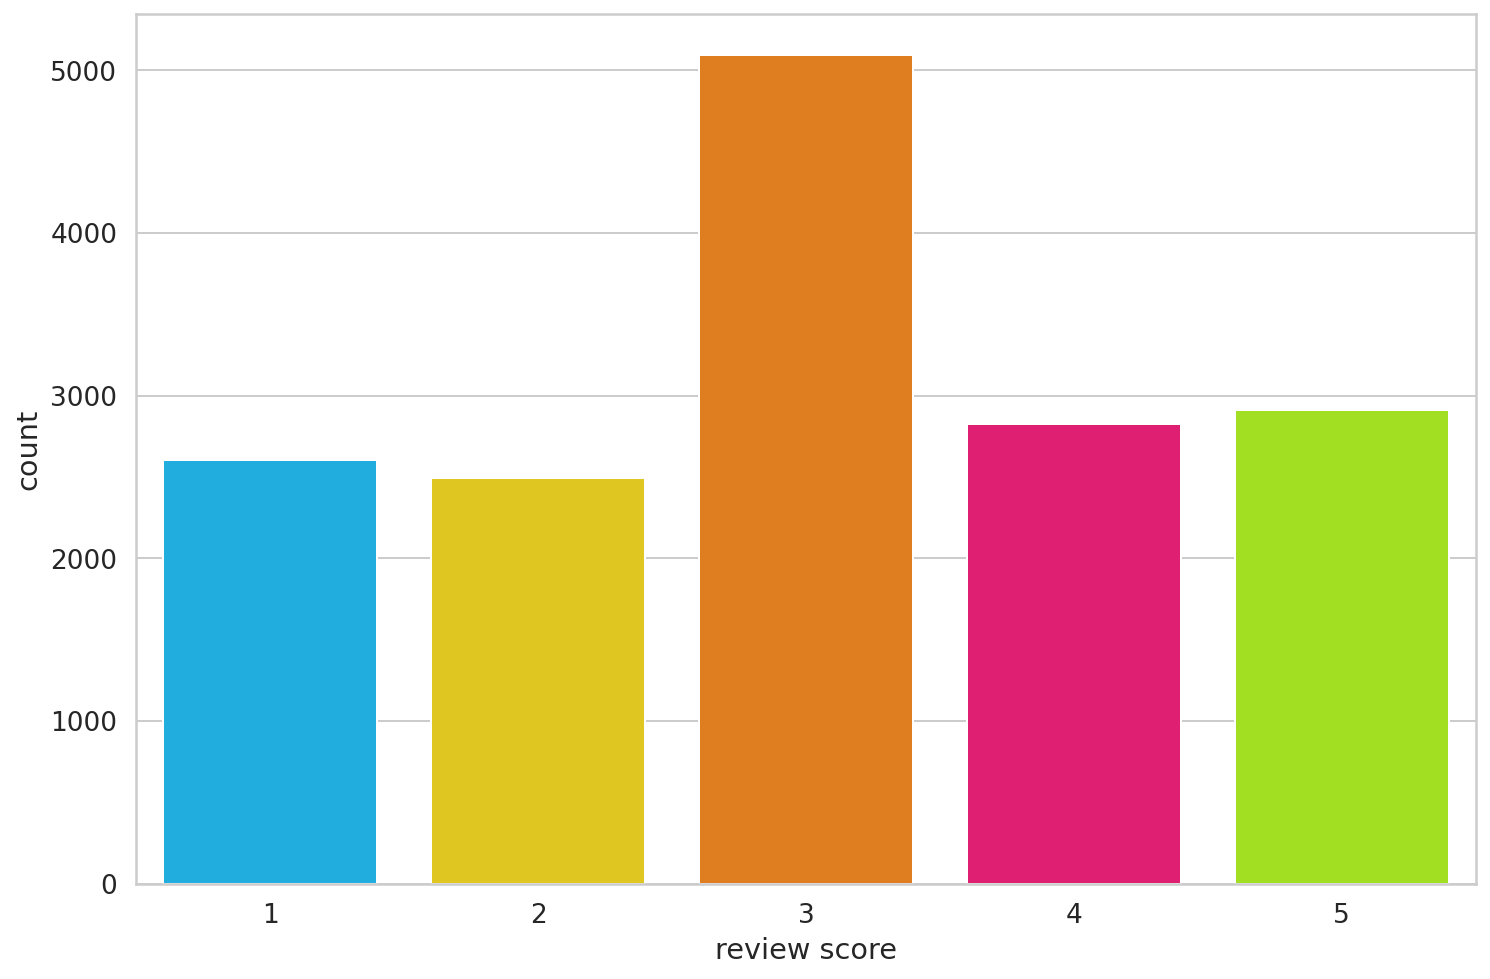

In [6]:
sns.countplot(df.score)
plt.xlabel('review score')